In [0]:
!pip install pandas
!pip install nltk
!pip install numpy
!pip install gensim
!pip install scikit-learn
!pip install matplotlib

In [0]:
ls

In [0]:
#Download Google Drive Dependencies
!apt-get update -qq 2>&1 > /dev/null
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse

In [0]:
# Generate auth tokens for Colab
from google.colab import auth
auth.authenticate_user()

In [0]:
# Generate creds for the Drive FUSE library.
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
# Work around misordering of STREAM and STDIN in Jupyter.
# https://github.com/jupyter/notebook/issues/3159
prompt = !google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass(prompt[0] + '\n\nEnter verification code: ')
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

In [0]:
# Create a directory and mount Google Drive using that directory.
!mkdir -p drive
!google-drive-ocamlfuse drive

print 'Files in Drive:'
!ls drive/

# Create a file in Drive.
!echo "This newly created file will appear in your Drive file list." > drive/created.txt

In [0]:
ls drive

In [0]:
import os
os.chdir("drive")

In [0]:
ls

In [0]:
import pandas as pd
import nltk
import math
import codecs
import csv
import sys
import math
from nltk.corpus import stopwords
from gensim.models.doc2vec import TaggedDocument, Doc2Vec
from sklearn.cluster import KMeans
from sklearn.utils import shuffle
import os

model_save_root = os.path.join('colab_tests','cluster_tests')
model_name = "movie-trained.model"
filename = os.path.join('colab_tests','cluster_tests','movies_metadata.csv')
test_filename = os.path.join('colab_tests','cluster_tests','test_movies_metadata.csv')

data = pd.read_csv(filename)
overview = data['overview'].astype('str').tolist()

# Split 90 - 10
total_length = len(overview)
test_length = int(math.floor(((total_length * 10)/100)))
train_length = total_length - test_length


# Shuffle the list
overview = filter(bool, overview)
overview = shuffle(overview)
train_set = overview[0:train_length]
test_set = overview[train_length: total_length]

#Create test csv from the test set
print("creating test file")
test_data_frame = pd.DataFrame(test_set, columns=["overview"])
test_data_csv = test_data_frame.to_csv()
test_file_handler = open(test_filename,"w+")
test_file_handler.write(test_data_csv)
test_file_handler.close()

class Documents(object):
    def __init__(self, documents):
        self.documents = documents

    def __iter__(self):
        for i, doc in enumerate(self.documents):
            yield TaggedDocument(words=doc, tags=[i])


documents = Documents(train_set)

model = Doc2Vec(vector_size=100, dbow_words=1, dm=0, epochs=20,  window=2, min_count=2, workers=4)

model.build_vocab(documents)

In [0]:
print("Training on {} documents".format(model.corpus_count))
model.train(documents, total_examples=model.corpus_count, epochs=model.epochs)


In [0]:
checkpoint_save_path = os.path.join(model_save_root,str(model.epochs)+"_cluster.model")
model.save(checkpoint_save_path)

{1: 820.5102212796877, 2: 483.39371793431235, 3: 391.7376069802646, 4: 334.9046389453258, 5: 299.7100344001613, 6: 285.0106343471107, 7: 270.81737110830016, 8: 259.44369841666713, 9: 252.41869755110824, 10: 246.71926643645025, 11: 240.585269219346, 12: 233.53882259021213, 13: 229.52718571790734, 14: 222.81039923776075}


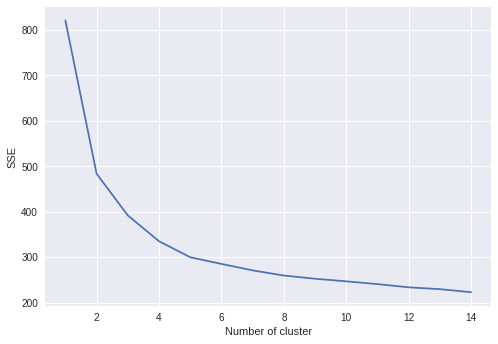

In [34]:
#Create cluster using K-Means
#Only creates graph
import matplotlib
#matplotlib.use('Agg')
import re
import os
import nltk, math, codecs
import csv
from nltk.corpus import stopwords
from gensim.models import Doc2Vec
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import pandas as pd

model_name = checkpoint_save_path
loaded_model = Doc2Vec.load(model_name)

#Load the test csv file
data = pd.read_csv(test_filename)
overview = data['overview'].astype('str').tolist()
overview = filter(bool, overview)
vectors = []

def split_words(text):
  return ''.join([x if x.isalnum() or x.isspace() else " " for x in text ]).split()

def preprocess_document(text):
  sp_words = split_words(text)
  return sp_words

for i, t in enumerate(overview):
  vectors.append(loaded_model.infer_vector(preprocess_document(t)))

sse = {}
for k in range(1,15):
  km = KMeans(n_clusters=k, max_iter=1000, verbose = 0).fit(vectors)
  sse[k] = km.inertia_
  
best_cluster_size = 1
min_error = float("inf")

for cluster_size in sse:
    if sse[cluster_size] < min_error:
        min_error = sse[cluster_size]
        best_cluster_size = cluster_size

print(sse)

plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()
#plt.savefig("sse_vs_number_of_clusters.png")

  

In [0]:
#Create cluster using K-Means
import matplotlib
#matplotlib.use('Agg')
import re
import os
import nltk, math, codecs
import csv
from nltk.corpus import stopwords
from gensim.models import Doc2Vec
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import pandas as pd

model_name = checkpoint_save_path
loaded_model = Doc2Vec.load(model_name)

#Load the test csv file
data = pd.read_csv(test_filename)
overview = data['overview'].astype('str').tolist()
overview = filter(bool, overview)
vectors = []

def split_words(text):
  return ''.join([x if x.isalnum() or x.isspace() else " " for x in text ]).split()

def preprocess_document(text):
  sp_words = split_words(text)
  return sp_words

for i, t in enumerate(overview):
  vectors.append(loaded_model.infer_vector(preprocess_document(t)))

km = KMeans(n_clusters=5, max_iter=1000, verbose = 0).fit(vectors)
clusters = km.labels_.tolist()
csvRows = []

for idx in range(len(overview)):
    csvRows.append({
        'overview': overview[idx],
        'cluster': clusters[idx]
    })

    
csv_data_frame = pd.DataFrame(csvRows, columns=["cluster","overview"])
cluster_csv = csv_data_frame.to_csv()

cluster_file_handler = open(os.path.join(model_save_root,"cluster.csv"),"w+")
cluster_file_handler.write(cluster_csv)
cluster_file_handler.close()